In [1]:
import h5py
import numpy as np
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

2025-09-16 18:03:42.198112: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 18:03:42.200186: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 18:03:42.235266: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 18:03:42.236050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-16 18:04:10.335489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
train_file = "fetch/train_data.hdf5"

with h5py.File(train_file, "r") as f:
    print("Top-level keys (groups or datasets):")
    for key in f.keys():
        print(" -", key)
        if isinstance(f[key], h5py.Group):
            print("   Contains datasets:", list(f[key].keys()))
        elif isinstance(f[key], h5py.Dataset):
            print("   Shape:", f[key].shape)
            print("   Dtype:", f[key].dtype)

Top-level keys (groups or datasets):
 - data_dm_time
   Shape: (40000, 256, 256, 1)
   Dtype: float32
 - data_freq_time
   Shape: (40000, 256, 256, 1)
   Dtype: float32
 - data_labels
   Shape: (40000,)
   Dtype: bool


In [3]:
from tensorflow.image import resize

# Load training data
with h5py.File(train_file, "r") as f:
    # X_train_ft = np.array(f["data_freq_time"], dtype=np.float32)
    X_train_dt = np.array(f["data_dm_time"], dtype=np.float32)
    y_train = np.array(f["data_labels"], dtype=int)

# Check the shape before resizing
print("Original X_train_dt shape:", X_train_dt.shape)
print("y_train shape:", y_train.shape)

# Resize each image from (256, 256, 1) to (64, 64, 1)
X_train = np.array([resize(img, (64, 64)) for img in X_train_dt])

# Ensure the reshaped X_train matches the number of labels in y_train
assert X_train.shape[0] == y_train.shape[0], "Mismatch between X_train and y_train samples"

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)

Original X_train_dt shape: (40000, 256, 256, 1)
y_train shape: (40000,)


2025-09-16 18:08:07.672948: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
test_file = "fetch/test_data.hdf5"

with h5py.File(test_file, "r") as f:
    print("Top-level keys (groups or datasets):")
    for key in f.keys():
        print(" -", key)
        # Check what’s inside each key
        if isinstance(f[key], h5py.Group):
            print("   Contains datasets:", list(f[key].keys()))
        elif isinstance(f[key], h5py.Dataset):
            print("   Shape:", f[key].shape)
            print("   Dtype:", f[key].dtype)

Top-level keys (groups or datasets):
 - data_dm_time
   Shape: (13983, 256, 256, 1)
   Dtype: float32
 - data_freq_time
   Shape: (13983, 256, 256, 1)
   Dtype: float32
 - data_labels
   Shape: (13983,)
   Dtype: bool


In [5]:
# Load test data
with h5py.File(test_file, "r") as f:
    # X_ft = np.array(f["data_freq_time"], dtype=np.float32)
    X_dt = np.array(f["data_dm_time"], dtype=np.float32)
    y_true = np.array(f["data_labels"], dtype=int)  # bool to int

# Check the shape before resizing
print("Original X_test_dt shape:", X_dt.shape)
print("y_true shape:", y_true.shape)

# Resize each image from (256, 256, 1) to (64, 64, 1)
X_test = np.array([resize(img, (64, 64)) for img in X_dt])

# One-hot encode the test labels
y_true = to_categorical(y_true, num_classes=2)

# Ensure the reshaped X_test matches the number of test labels
assert X_test.shape[0] == y_true.shape[0], "Mismatch between X_test and y_true samples"

Original X_test_dt shape: (13983, 256, 256, 1)
y_true shape: (13983,)


In [7]:
# Now X_train, X_test, y_train, y_true should all be correctly shaped
print("Final shapes:")
print("X_train_resized shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test_resized shape:", X_test.shape)
print("y_true shape:", y_true.shape)

Final shapes:
X_train_resized shape: (40000, 64, 64, 1)
y_train shape: (40000, 2)
X_test_resized shape: (13983, 64, 64, 1)
y_true shape: (13983, 2)


In [8]:
def create_simple_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(2, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))  # Output layer for 2 classes (RFI, FRB)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the input shape (assuming X_ft has shape [samples, height, width, 1])
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Create the model
model = create_simple_cnn(input_shape)

In [9]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0596 - accuracy: 0.9783 - val_loss: 0.6865 - val_accuracy: 0.7810
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0133 - accuracy: 0.9962 - val_loss: 0.5612 - val_accuracy: 0.8253
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 1.6696 - val_accuracy: 0.7195
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.8571 - val_accuracy: 0.8064
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.9036 - val_accuracy: 0.8077
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 1.4498 - val_accuracy: 0.7771
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 1.9461 - val_accuracy:

437/437 [==============================] - 0s 730us/step
Test Accuracy: 0.8778516770364013
Confusion matrix:
 [[7238   81]
 [1627 5037]]
              precision    recall  f1-score   support

         RFI       0.82      0.99      0.89      7319
         FRB       0.98      0.76      0.86      6664

    accuracy                           0.88     13983
   macro avg       0.90      0.87      0.87     13983
weighted avg       0.90      0.88      0.88     13983

AUC (FRB as positive): 0.9674232379110956


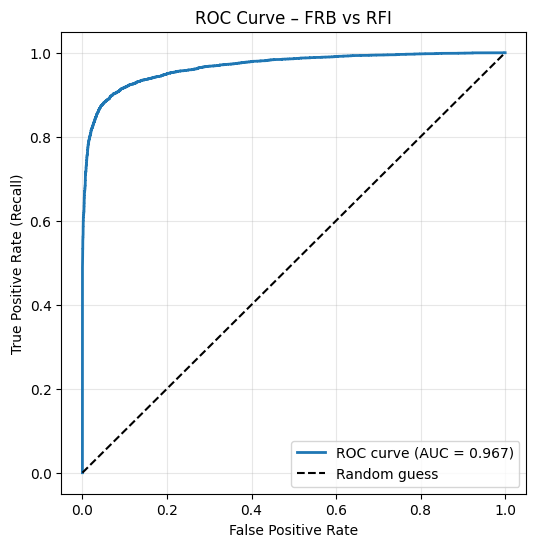

In [10]:
# Make predictions
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)  # Predicted classes

# Compute accuracy
acc = accuracy_score(np.argmax(y_true, axis=1), y_pred)  # Use argmax on y_true for comparison
print("Test Accuracy:", acc)

# Confusion Matrix and Classification Report
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)
report = classification_report(np.argmax(y_true, axis=1), y_pred, target_names=["RFI", "FRB"])
print("Confusion matrix:\n", cm)
print(report)

# Compute ROC AUC for FRB (class 1 as positive)
p_frb = y_prob[:, 1]  # probability of class 'FRB'
auc = roc_auc_score(np.argmax(y_true, axis=1), p_frb)
print("AUC (FRB as positive):", auc)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(np.argmax(y_true, axis=1), p_frb)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – FRB vs RFI")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()